# Data Playground

## Data Connections

In [2]:
import pandas as pd
import os
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
import sklearn as skl
import pandasql as ps
from pandasql import sqldf
import psycopg2
import csv
import sqlalchemy    
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from plotly import graph_objects as go
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
import itertools
import scipy.stats as scp
import warnings
import seaborn as sns
sns.set_style("ticks")
#sns.set_context("poster")
from matplotlib import rcParams

rcParams['figure.figsize'] = 32,24

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 5000)

## Datasets

In [82]:
df_demos = pd.read_csv('census-profiles.csv', delimiter=",")
df_demos.columns = ["ID", "Variable", "ArbutusRidge", "Downtown", "DunbarSouthlands", "Fairview",
                   "GrandviewWoodland", "HastingsSunrise", "KensingtonCedarCottage", "Kerrisdale", 
                   "Killarney", "Kitsilano", "Marpole", "MountPleasant", "Oakridge", "RenfrewCollingwood",
                   "RileyPark", "Shaughnessy", "SouthCambie", "Strathcona", "Sunset", "VictoriaFraserview",
                   "WestEnd", "WestPointGrey", "VancouverCSD", "VancouverCMA"]
with open('demo_cleanup.sql') as f:
    query_demo_cleanup = f.read()  
df_demos_cleaned = sqldf(query_demo_cleanup)

df_permits = pd.read_csv('issued-building-permits.csv', delimiter = ";")
df_permits_multi = pd.read_csv('permits-over-time-multi.csv')
df_2022_election = pd.read_csv('2022_voting_results.csv')
df_population_density = pd.read_csv('neighborhood_population_densities.csv')

## Permits Granted Over Time VS Neighborhood

<Figure size 2304x1728 with 0 Axes>

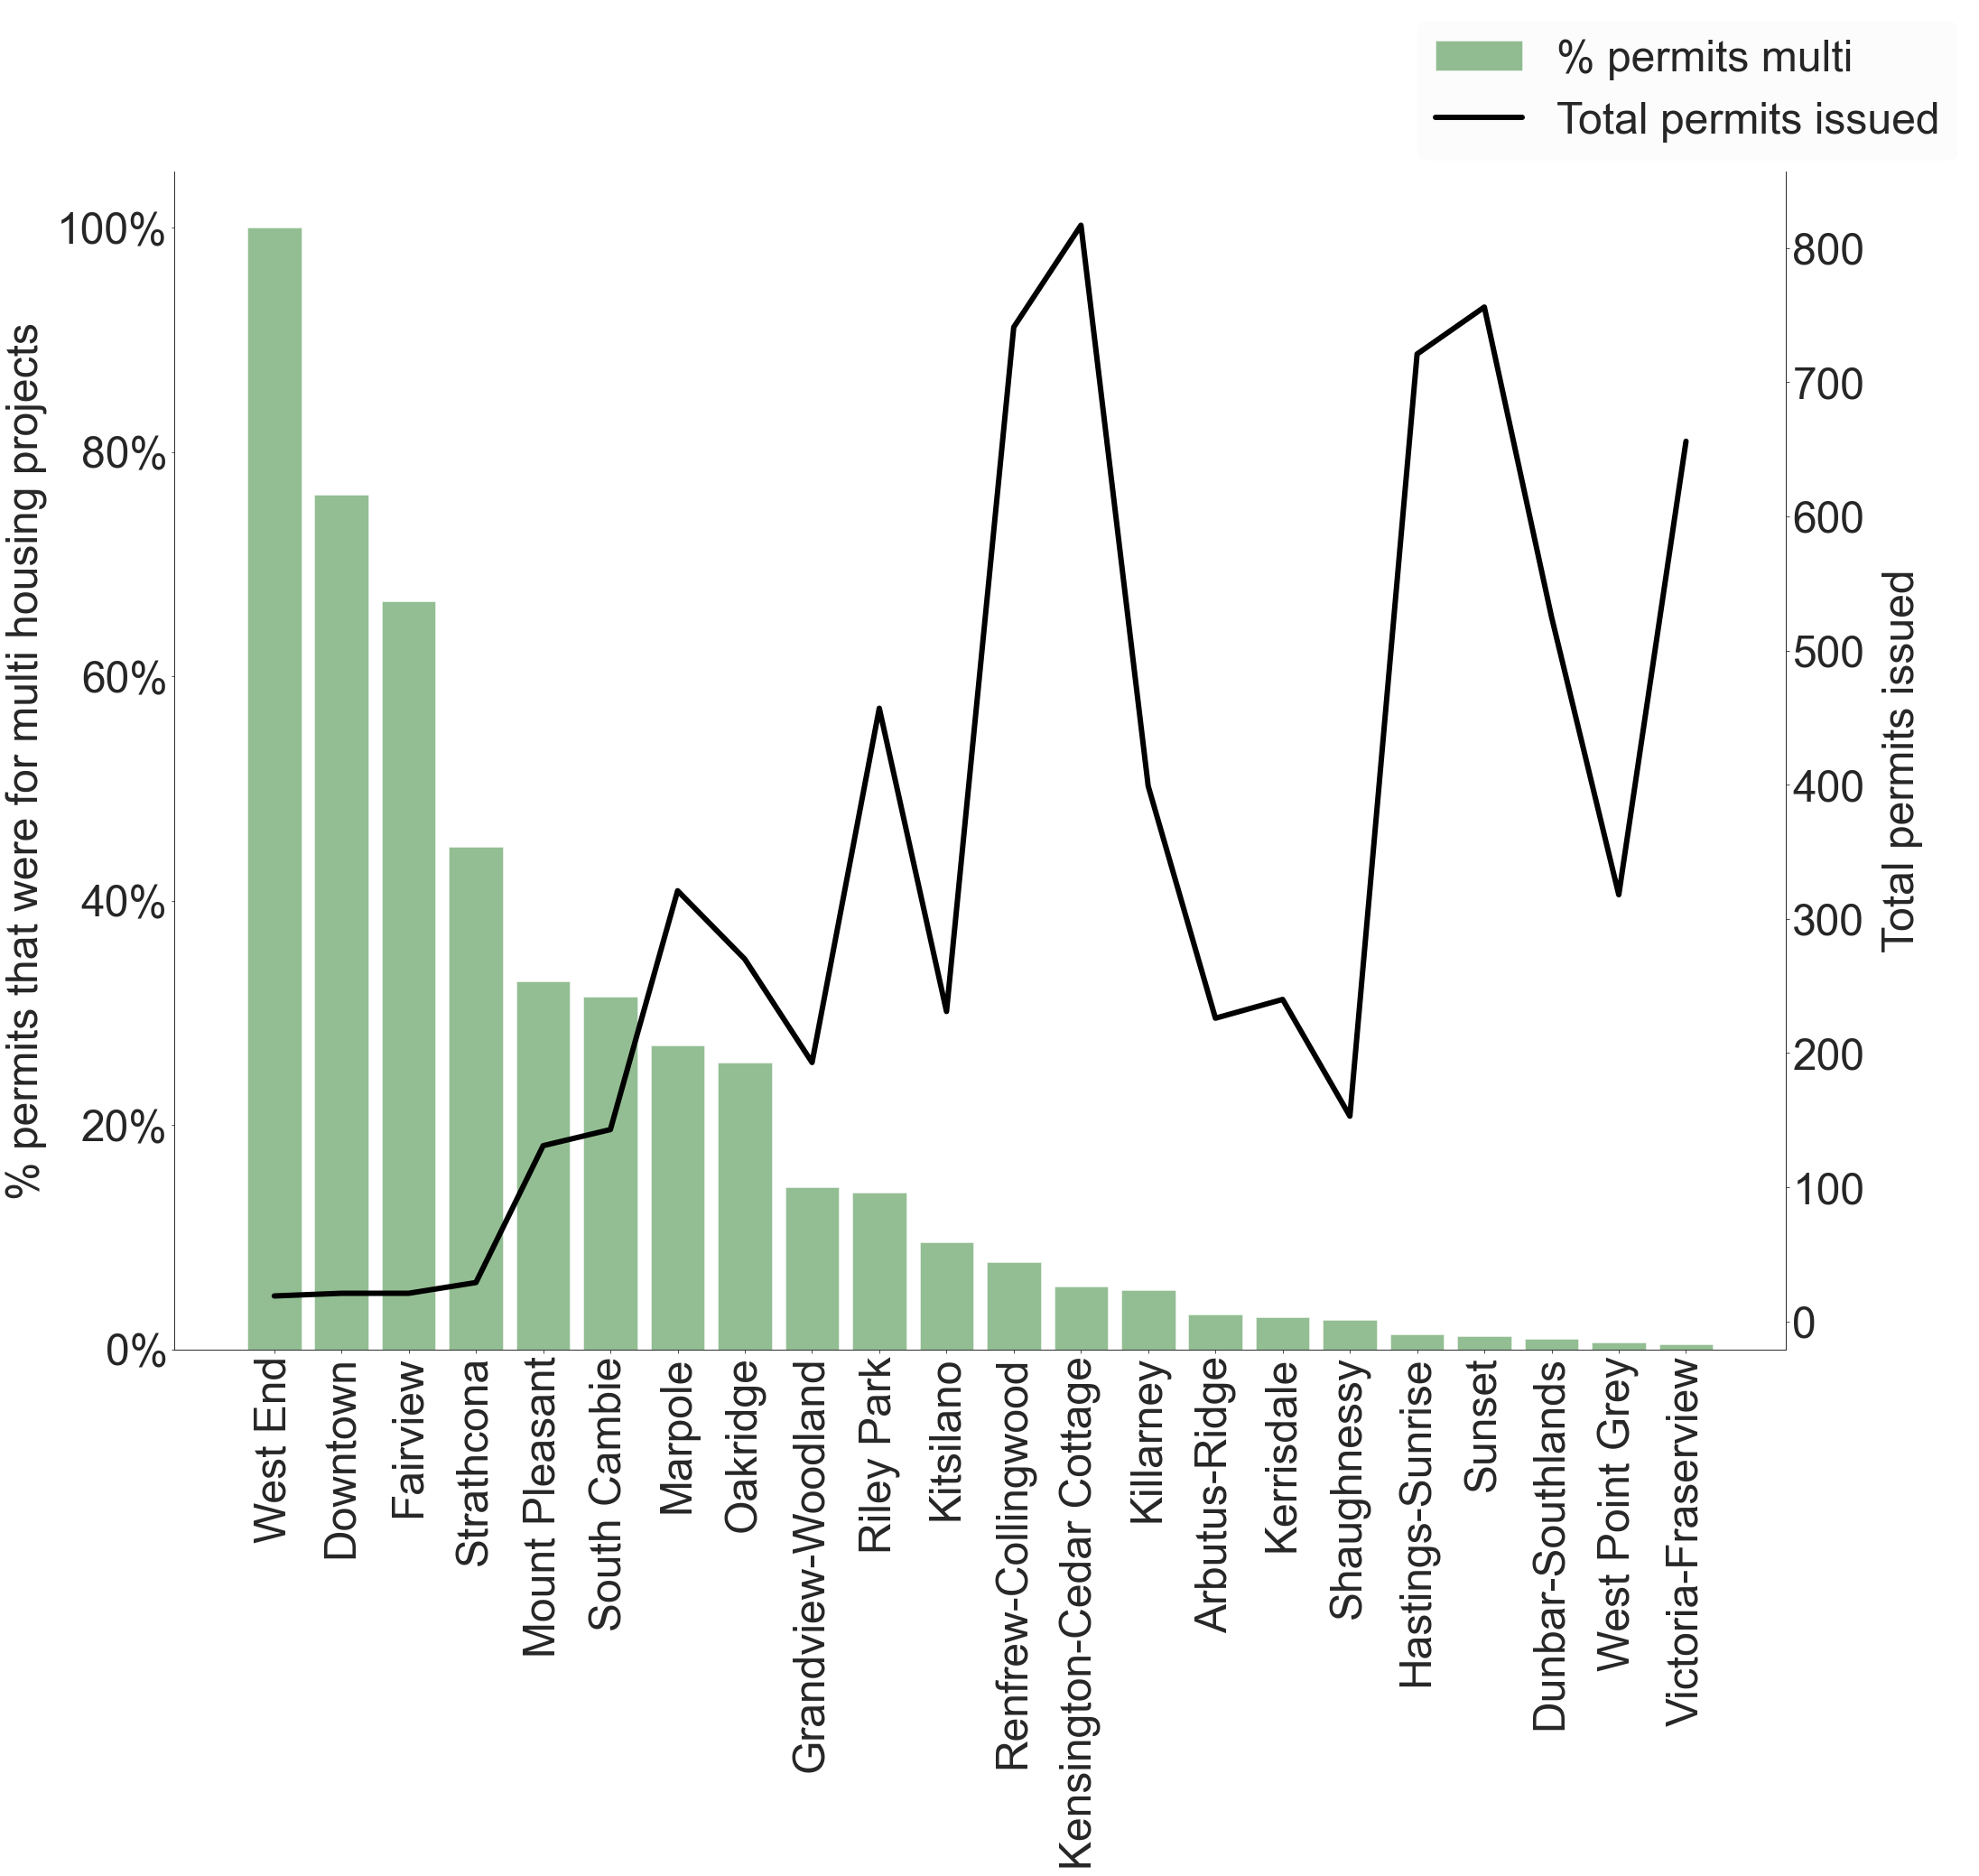

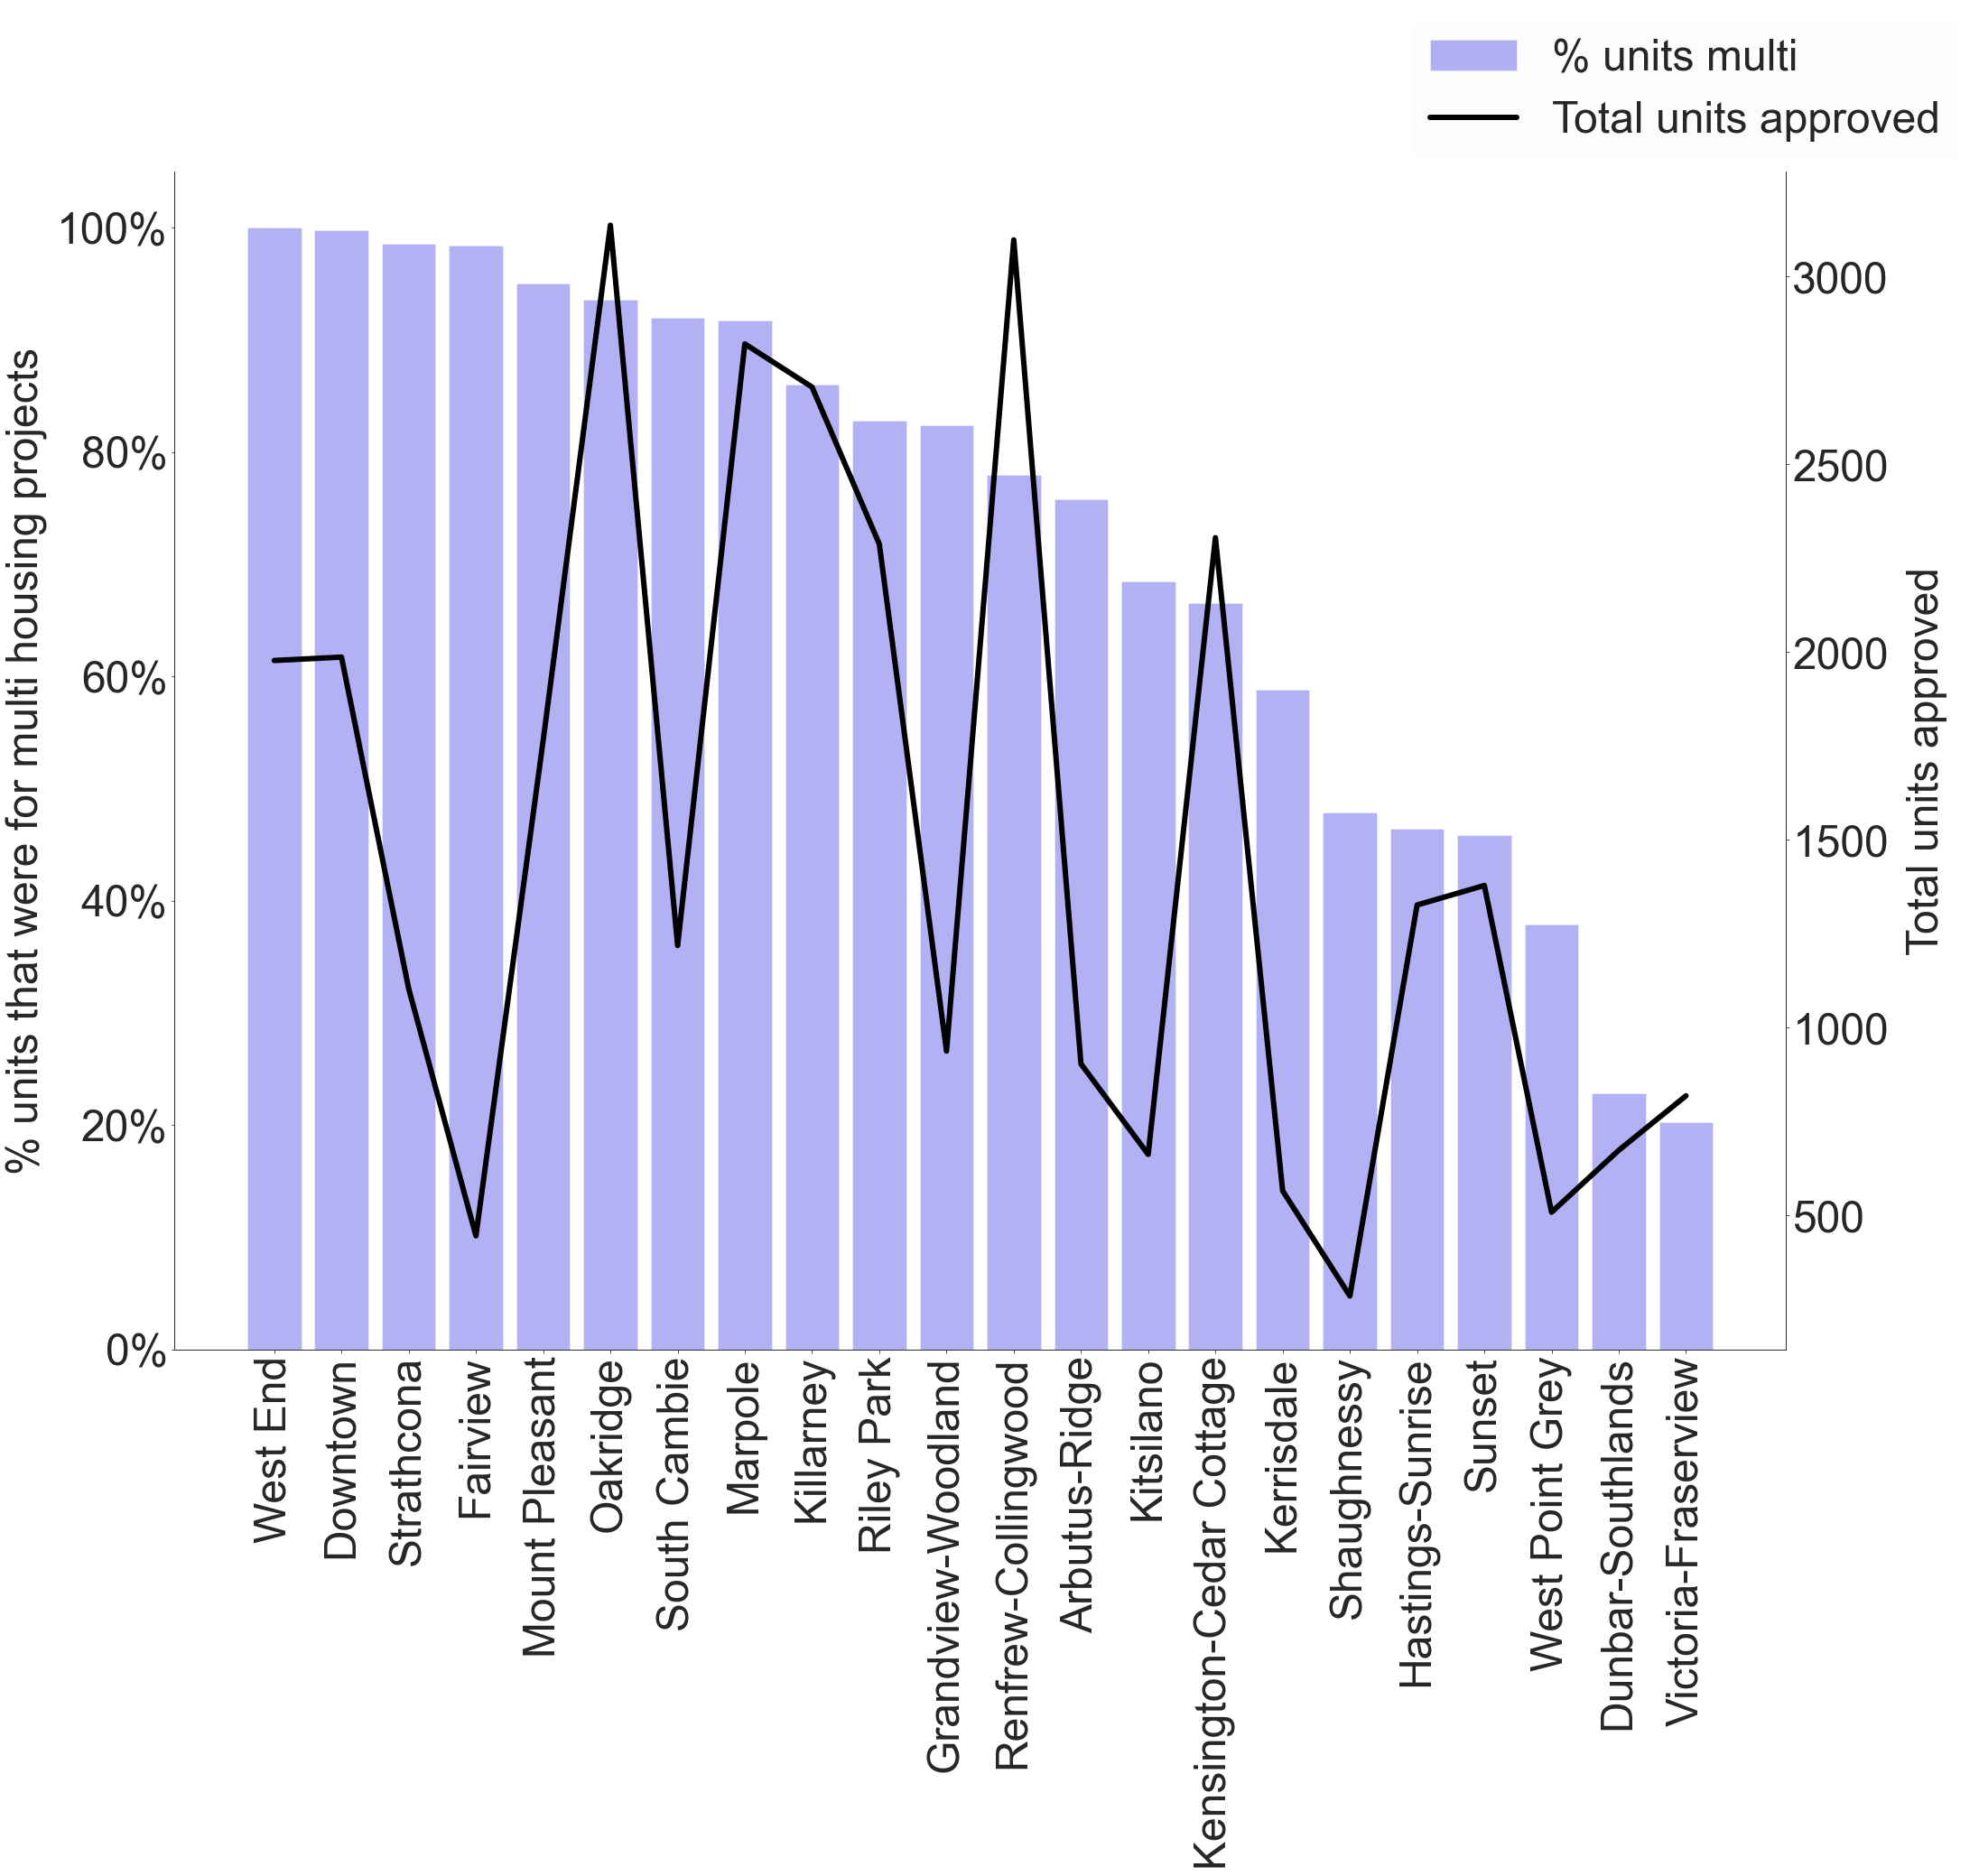

In [36]:
#----- getting all permits granted over time, with year as a column
with open('permits_over_time.sql') as f:
    query_permits_granted_time_series = f.read()
permits_granted_time_series = sqldf(query_permits_granted_time_series)

#----- aggregating the above table over years... it turns out that collapsing data helps visualize

with open('permits_over_time_cumulative.sql') as f:
    query_permits_granted_cumulative = f.read()
permits_granted_time_series_cumulative = sqldf(query_permits_granted_cumulative)

#----- sorting dataframes for graphing
permits_granted_time_series_cumulative_multi = permits_granted_time_series_cumulative.loc[permits_granted_time_series_cumulative['PropertyType'] == 'multi']
permits_granted_time_series_cumulative_multi = permits_granted_time_series_cumulative_multi.sort_values(by=['PercentTotalPermits'], ascending=False)
units_granted_time_series_cumulative_multi = permits_granted_time_series_cumulative_multi.sort_values(by=['PercentTotalUnits'], ascending=False)

plt.clf() #clear any sort of diagrams made prior

#----- figure one for permit volume and % multi
fig_1 = plt.figure()
ax1 = fig_1.add_subplot(111)
sns.barplot(data=permits_granted_time_series_cumulative_multi, 
             x="GeoLocalArea", y="PercentTotalPermits", color = "green", alpha = 0.45,
                   label = '% permits multi')
plt.xticks(rotation=90)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.set_ylabel('% permits that were for multi housing projects', labelpad=10, fontsize = 48)
ax1.set_xlabel('')
ax1.tick_params(axis='both', which='major', labelsize=48)

ax2 = plt.twinx()
sns.lineplot(data=permits_granted_time_series_cumulative_multi, 
             x="GeoLocalArea", y="GrandTotalPermits", color="black", ax=ax2, linewidth = 6,
                    label = 'Total permits issued', legend = False)
ax2.set_ylabel('Total permits issued', labelpad = 20, fontsize = 48)
ax2.set_xlabel('')
ax2.tick_params(axis='both', which='major', labelsize=48)

fig_1.legend(loc="upper right", facecolor = 'black', framealpha = 0.01, fontsize = 48)
sns.despine(bottom = False, left = False, right = False)
plt.savefig('permits_issued_percent_multi_neighborhood.png', bbox_inches='tight')

#----- figure two for unit volume and % multi
fig_2 = plt.figure()
ax3 = fig_2.add_subplot(111)
sns.barplot(data=units_granted_time_series_cumulative_multi, 
             x="GeoLocalArea", y="PercentTotalUnits", color = "blue", alpha = 0.35,
                   label = '% units multi')
plt.xticks(rotation=90)
ax3.yaxis.set_major_formatter(mtick.PercentFormatter())
ax3.set_ylabel('% units that were for multi housing projects', labelpad = 10, fontsize = 48)
ax3.set_xlabel('')
ax3.tick_params(axis='both', which='major', labelsize=48)

ax4 = plt.twinx()
sns.lineplot(data=units_granted_time_series_cumulative_multi, 
             x="GeoLocalArea", y="GrandTotalUnits", color="black", ax=ax4, linewidth = 6,
                    label = 'Total units approved', legend = False)
ax4.set_ylabel('Total units approved', labelpad = 20, fontsize = 48)
ax4.set_xlabel('')
ax4.tick_params(axis='both', which='major', labelsize=48)

fig_2.legend(loc="upper right", facecolor = 'black', framealpha = 0.01, fontsize = 48)
sns.despine(bottom = False, left = False, right = False)
plt.savefig('units_approved_percent_multi_neighborhood.png', bbox_inches='tight')

## Feature Exploration - Correlating Features by Neighborhood

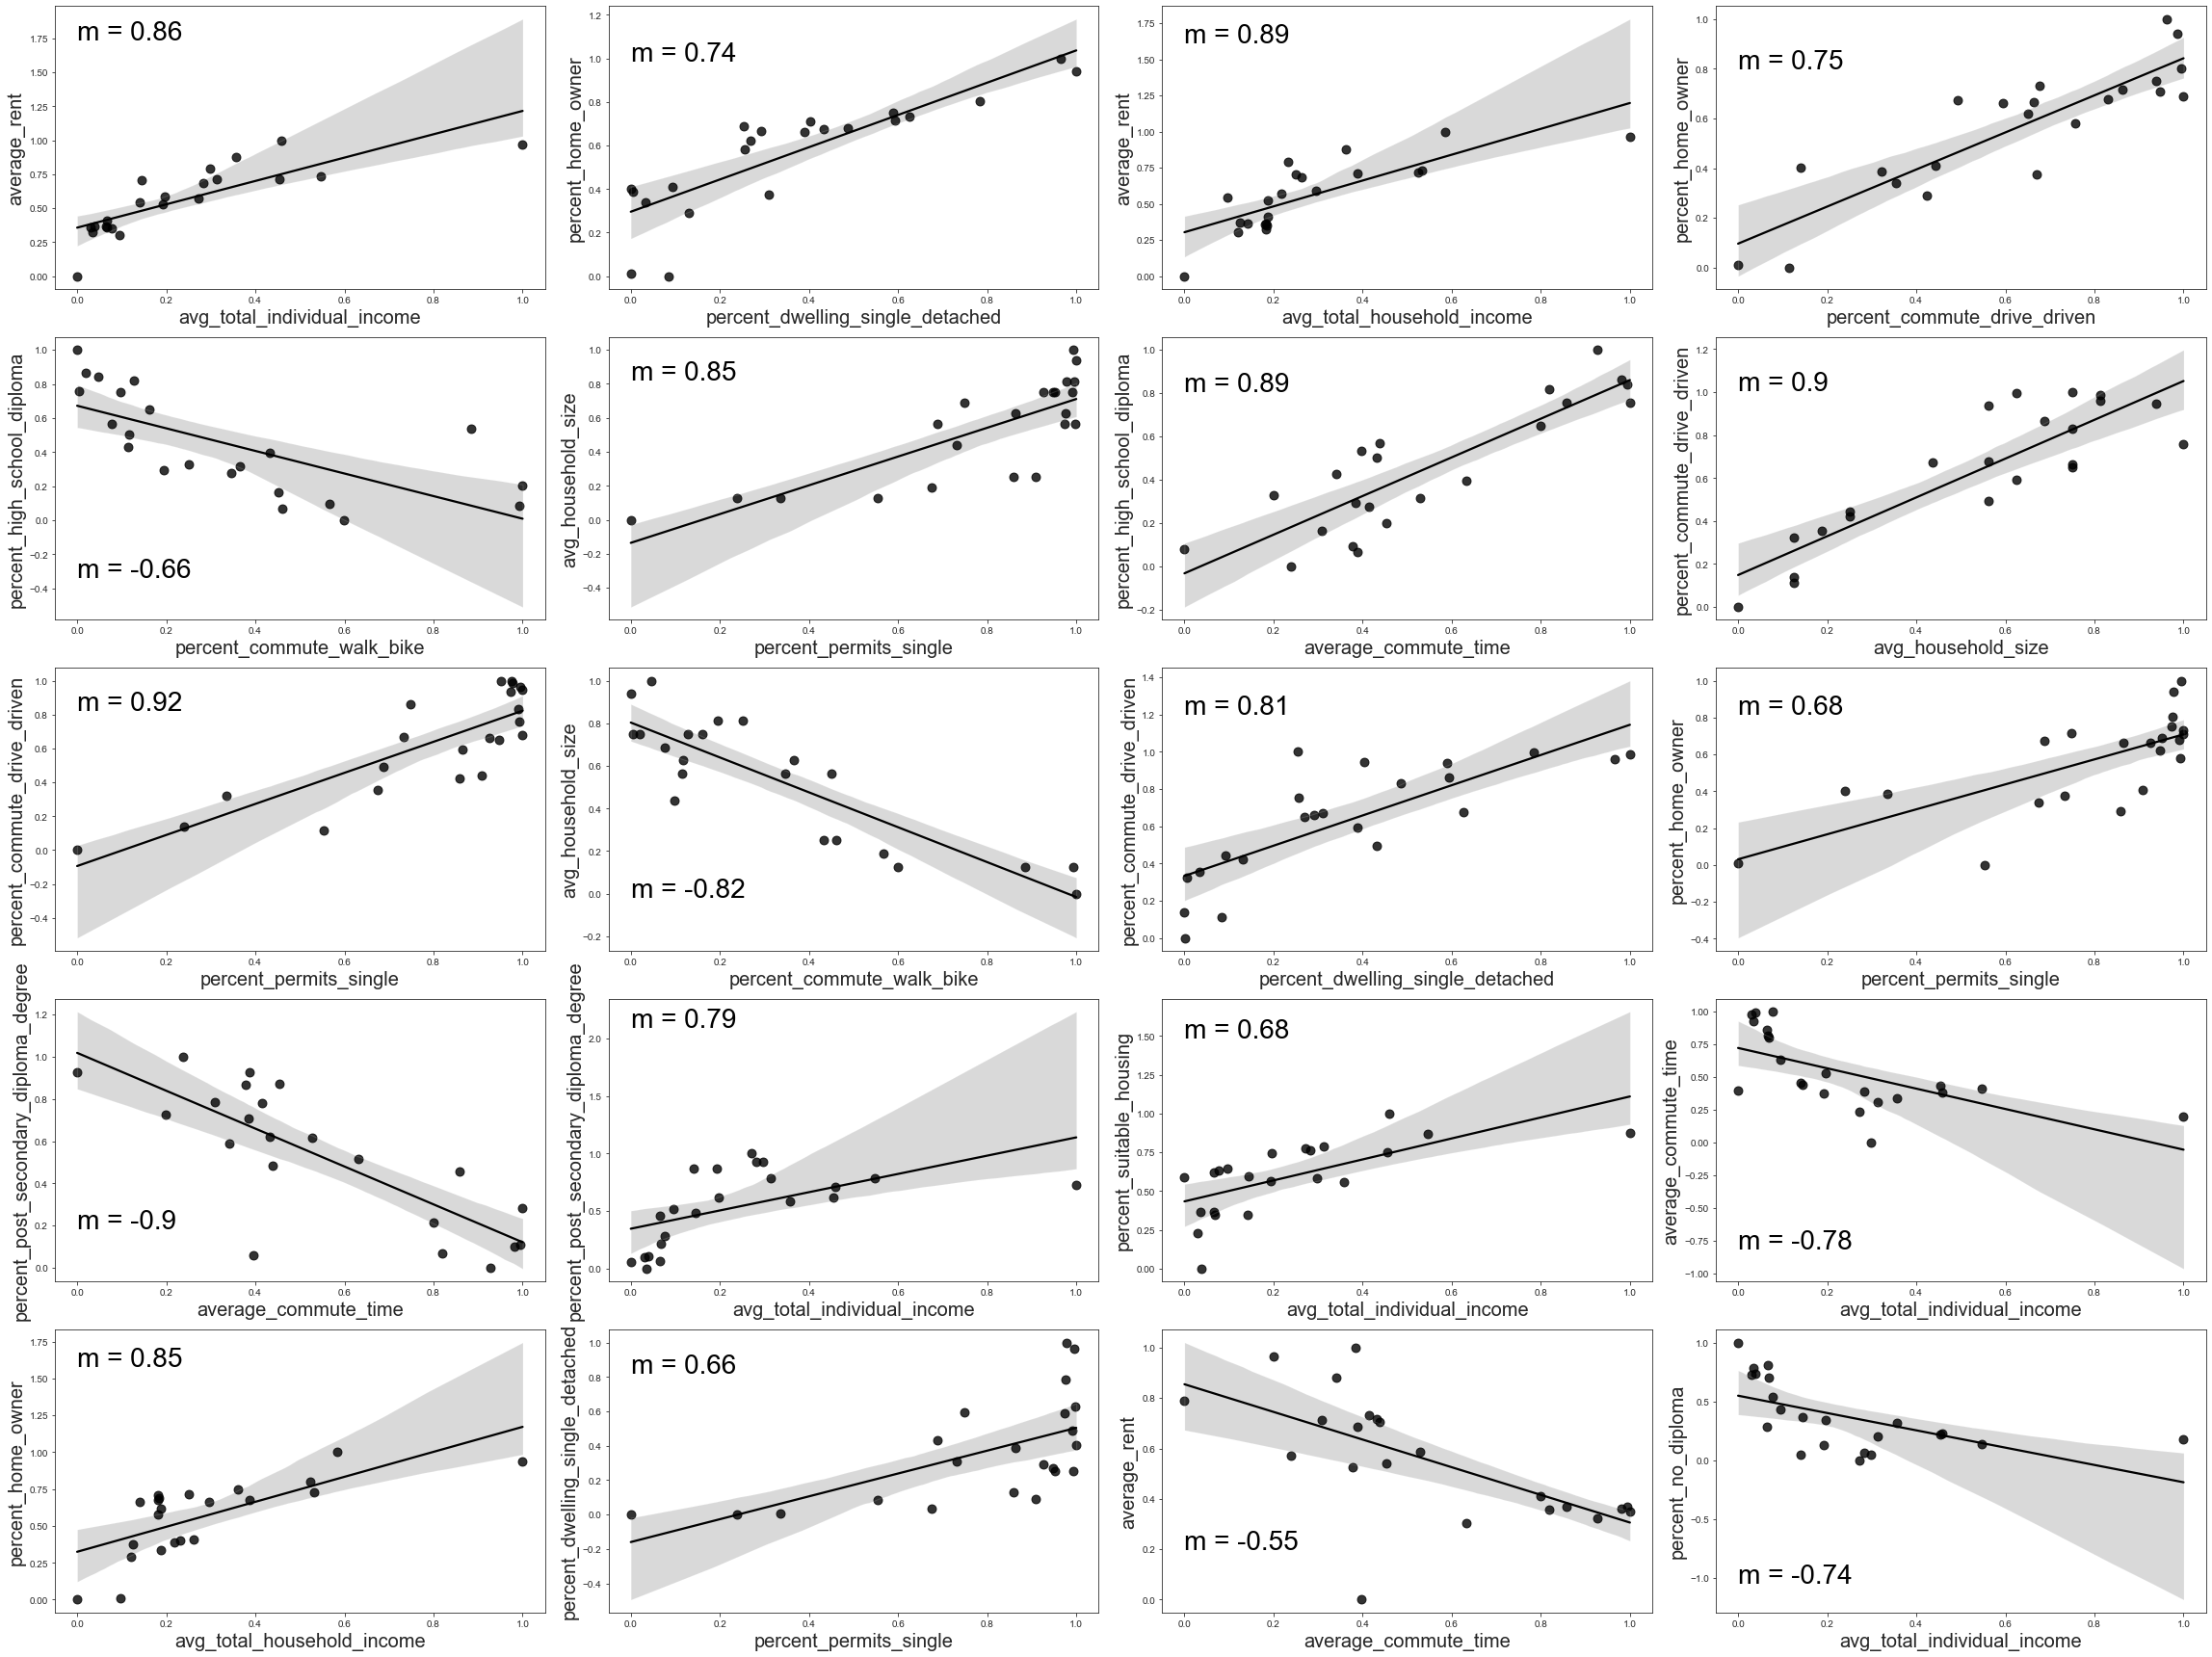

In [35]:
#----- getting the actual feature set from query!
with open('neighborhood_feature_set.sql') as f:
    query_feature_set = f.read()

features_not_normalized = sqldf(query_feature_set) #this query grabs our feature set specified

#----- pretty-fying the feature set
df_no_head = features_not_normalized.drop(columns=['locale']) #remove the neighborhood text prior to norming
scaler = MinMaxScaler(feature_range=(0, 1), copy=True) #boot up minmaxscaler
scaler.fit(df_no_head)
features_normalized = pd.DataFrame(scaler.transform(df_no_head), index=df_no_head.index, columns=df_no_head.columns)
features_normalized = pd.concat([features_not_normalized['locale'], features_normalized], axis=1) #re-add neighborhood
feat_norm_ag = features_normalized.drop(columns=['locale', 'total_permits']) #agnostic/blind version

#----- spearman correlation magic in a loop
#we have 17 features, so we need to loop in pairs from 0 to 16, i.e. 0, 1; 0, 2; 0, 3;...
unique_list = [] #many pairs are dupes because order doesn't matter, we want to remove dupes
corr_results = ['var_1', 'var_2', 'correlation', 'correlation_abs', 'pvalue'] #header for array initialized
for i in range(0, 16):
    for j in range(0, 16):
        if i != j:
            correlation, pvalue = scp.spearmanr(feat_norm_ag.iloc[:,i], feat_norm_ag.iloc[:,j])
            if (correlation not in unique_list):
               # correlation, pvalue = scp.spearmanr(feat_norm_ag.iloc[:,i], feat_norm_ag.iloc[:,j])
                temp_row = [feat_norm_ag.columns[i], feat_norm_ag.columns[j], float(correlation), 
                            float(abs(correlation)), float(pvalue)]
                corr_results = np.vstack([corr_results, temp_row]) #add new rows to array for new pair of vars
                unique_list.append(correlation) #exact correlation as unique

#----- final correlation results in a df
corr_results = np.delete(corr_results, (0), axis=0) #drop the array header
corr_results_df = pd.DataFrame(corr_results, columns = ['v1','v2','corr', 'corr_abs', 'p']) #turn the array into a df

#----- cleaning up results
# strong correlation is typically > 0.7 [https://geographyfieldwork.com/SpearmansRankCalculator.html]
filter1 = corr_results_df['corr_abs'].astype(float) >= 0.7
# a good p value is < 0.05
filter2 = corr_results_df['p'].astype(float) <= 0.05
# filtering using both conditions above
corr_results_df = corr_results_df.where(filter1 & filter2)
corr_results_df = corr_results_df.sort_values(by='corr_abs', ascending=False)
corr_results_df = corr_results_df.dropna()
corr_results_df.reset_index(drop=True, inplace=True)
corr_results_df.to_csv('neighborhood_correlating_factors.csv', index=False)

#----- next up is graphing the highly correlating pairs (there are 20 of them)
n_corr_factors = pd.read_csv('neighborhood_correlating_factors_cleaned.csv', delimiter=",")
fig_3 = plt.figure()

for k in range(1, 21):
    # first, let's get the linear regression values
    slope, intercept, r_value, p_value, std_err = scp.linregress(features_normalized[n_corr_factors.iloc[k-1, 0]],
                                                                   features_normalized[n_corr_factors.iloc[k-1, 1]])
    slope = round(slope, 2)
    temp_ax = fig_3.add_subplot(5,4,k)
    sns.regplot(data=features_normalized[n_corr_factors.iloc[k-1, 0:2]], 
                x=features_normalized[n_corr_factors.iloc[k-1, 0:2]].columns[0], 
                y=features_normalized[n_corr_factors.iloc[k-1, 0:2]].columns[1], 
                label="m = "+str(slope),
                color="black", 
                ax=temp_ax,
                scatter_kws={'s':80}
               )
    temp_ax.set_ylabel(features_normalized[n_corr_factors.iloc[k-1, 0:2]].columns[1], fontsize = 20)
    temp_ax.set_xlabel(features_normalized[n_corr_factors.iloc[k-1, 0:2]].columns[0], fontsize = 20)
    
    ybottom, ytop = temp_ax.get_ylim() #we want annotation to fit in space depending on y bounds
    if slope >= 0:
        xcoord_annotate = 0
        ycoord_annotate = ytop - 0.25
    else:
        xcoord_annotate = 0
        ycoord_annotate = ybottom + 0.25
    plt.text(xcoord_annotate, ycoord_annotate, "m = "+str(slope), 
             horizontalalignment='left', size=28, color='black') #slope annotation implemented

fig_3.tight_layout()

plt.savefig('neighborhood_correlating_factors_regressed.png', bbox_inches='tight')


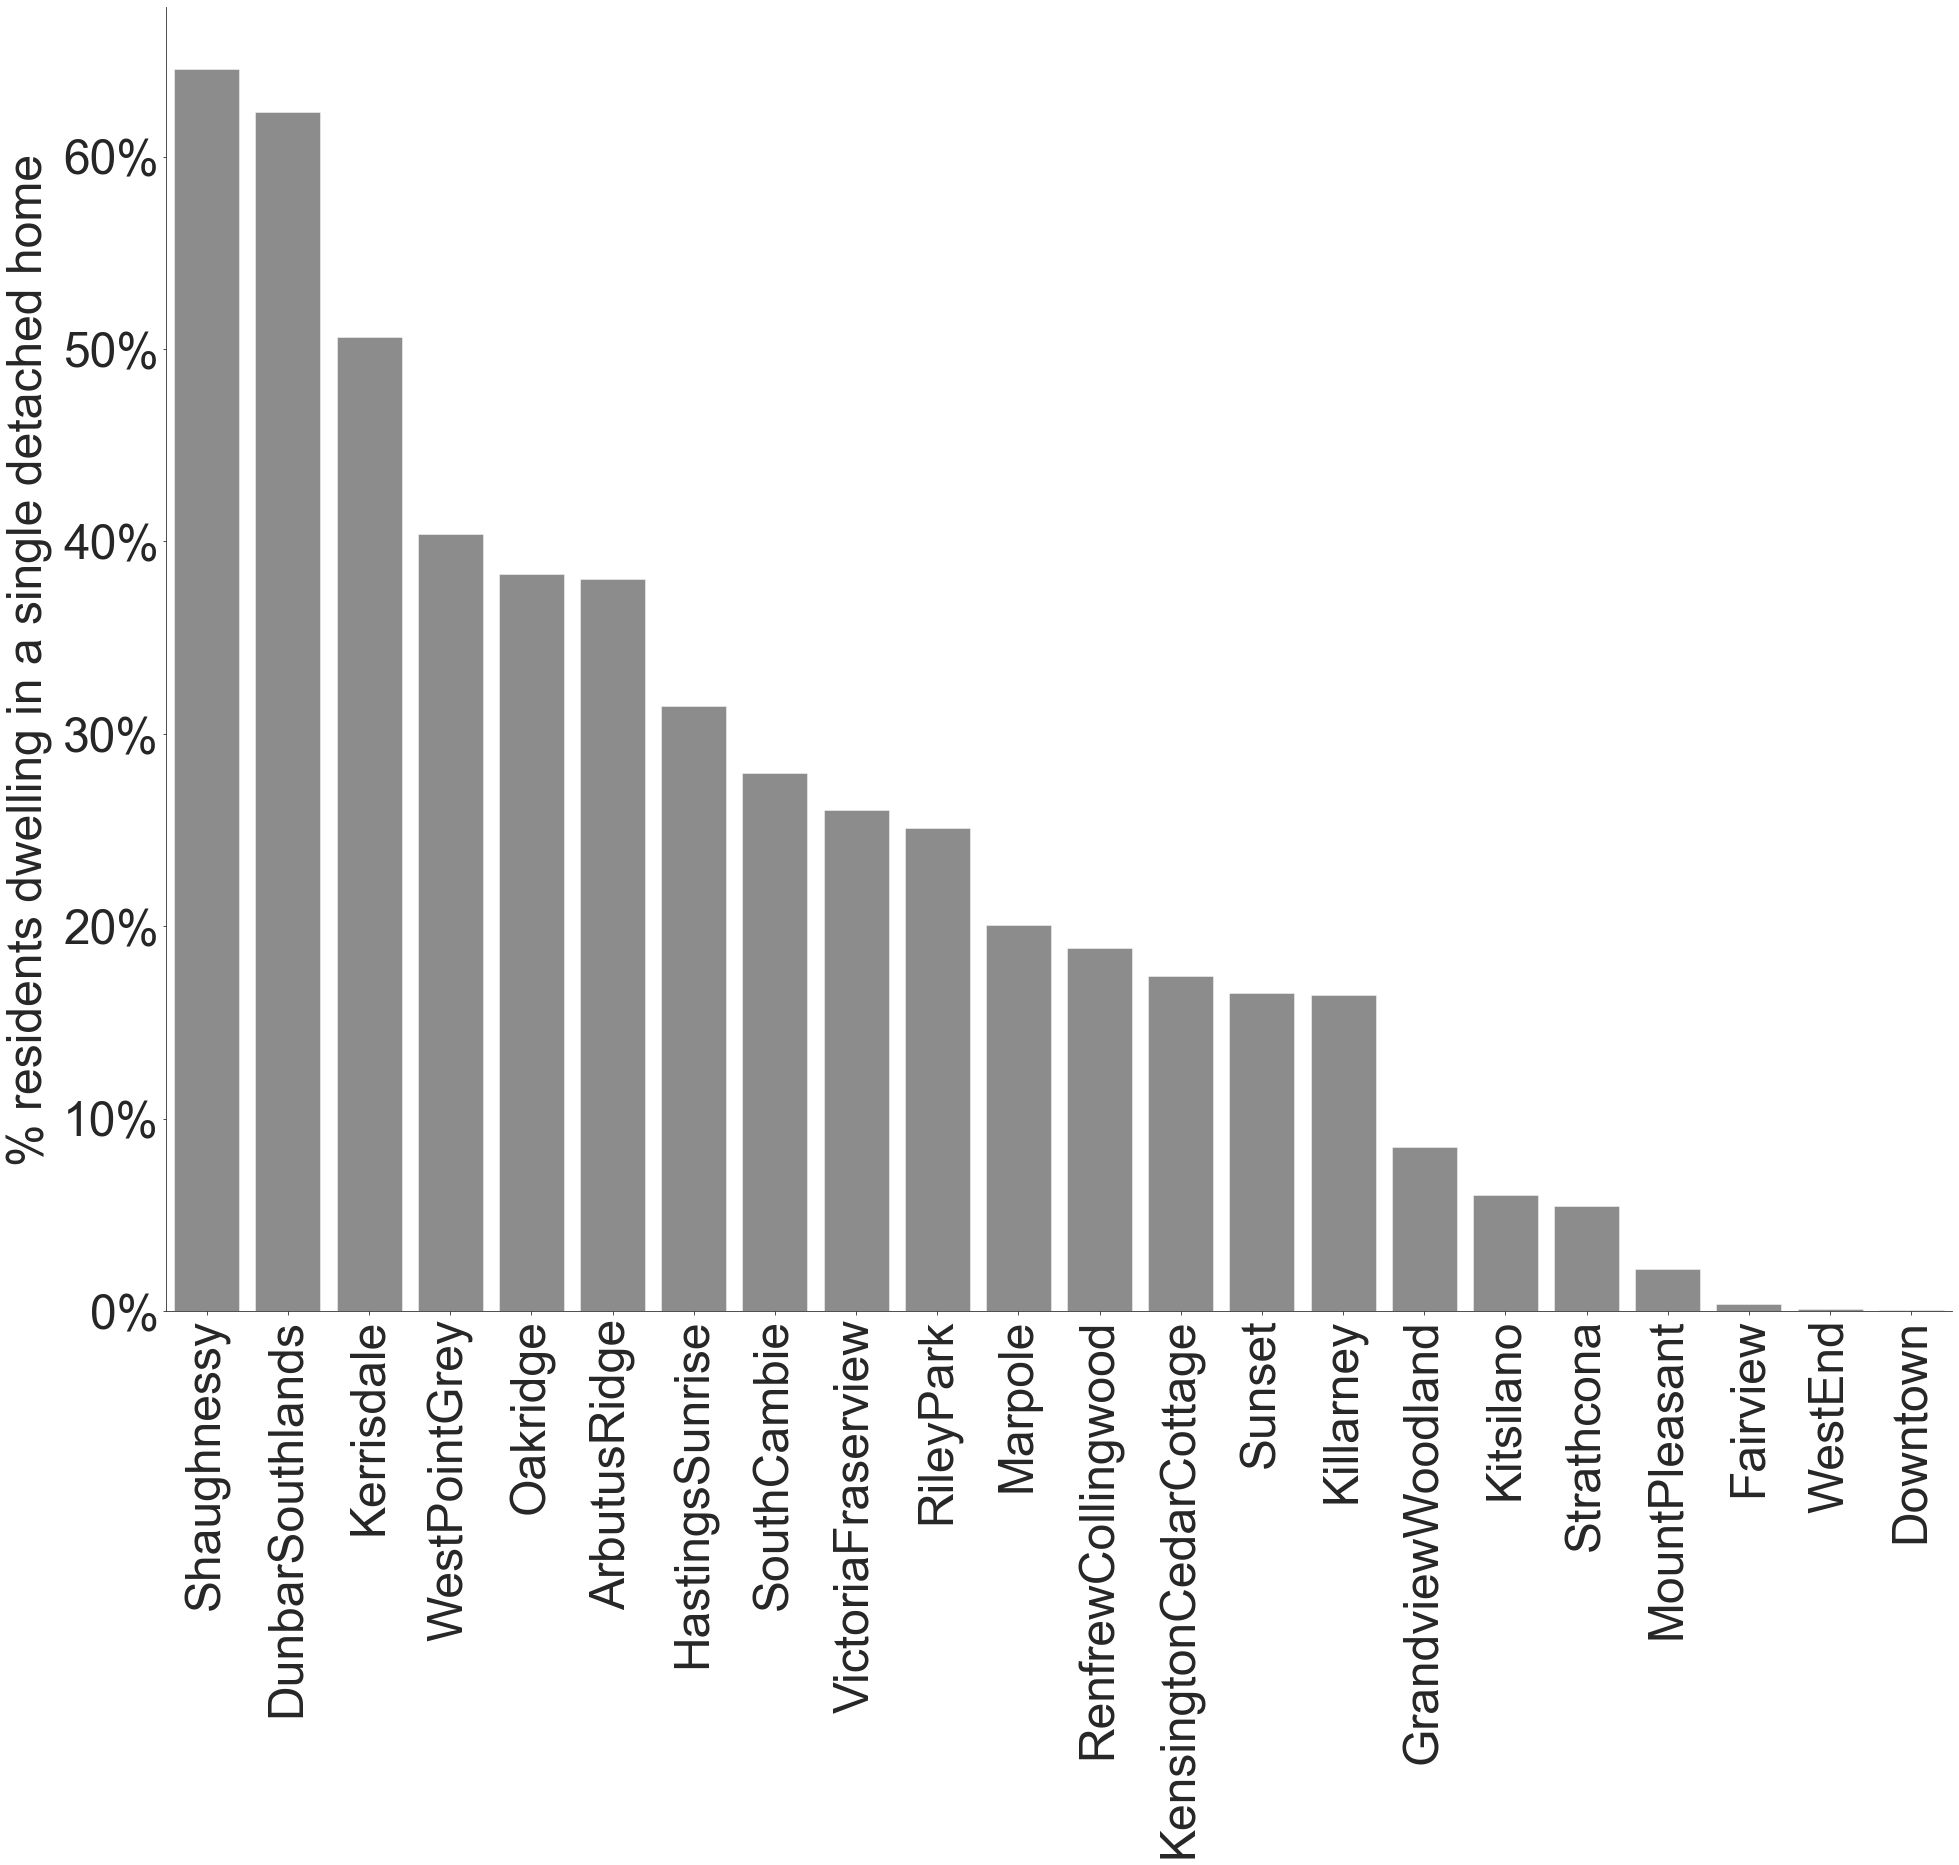

In [126]:
#----- Graphing how many dwellings in each neighborhood are single detached type
percent_single_detached_nb = features_not_normalized[['locale', 'percent_dwelling_single_detached']]
percent_single_detached_nb.percent_dwelling_single_detached *=100

#----- Sorting for the plot
percent_single_detached_nb_sorted = percent_single_detached_nb.sort_values(by=['percent_dwelling_single_detached'], 
                                                                           ascending=False)

fig_4 = plt.figure()
ax5 = fig_4.add_subplot(111)
sns.barplot(data=percent_single_detached_nb_sorted, 
             x="locale", y="percent_dwelling_single_detached", color = "black", alpha = 0.45,
                   label = '% residents dwelling in a single detached home')
plt.xticks(rotation=90)
ax5.yaxis.set_major_formatter(mtick.PercentFormatter())
ax5.set_ylabel('% residents dwelling in a single detached home', labelpad=10, fontsize = 48)
ax5.set_xlabel('')
ax5.tick_params(axis='both', which='major', labelsize=48)

sns.despine(bottom = False, left = False)
plt.savefig('percent_single_detached_by_neighborhood.png', bbox_inches='tight')

-0.5844717220491858 0.004282389154437954


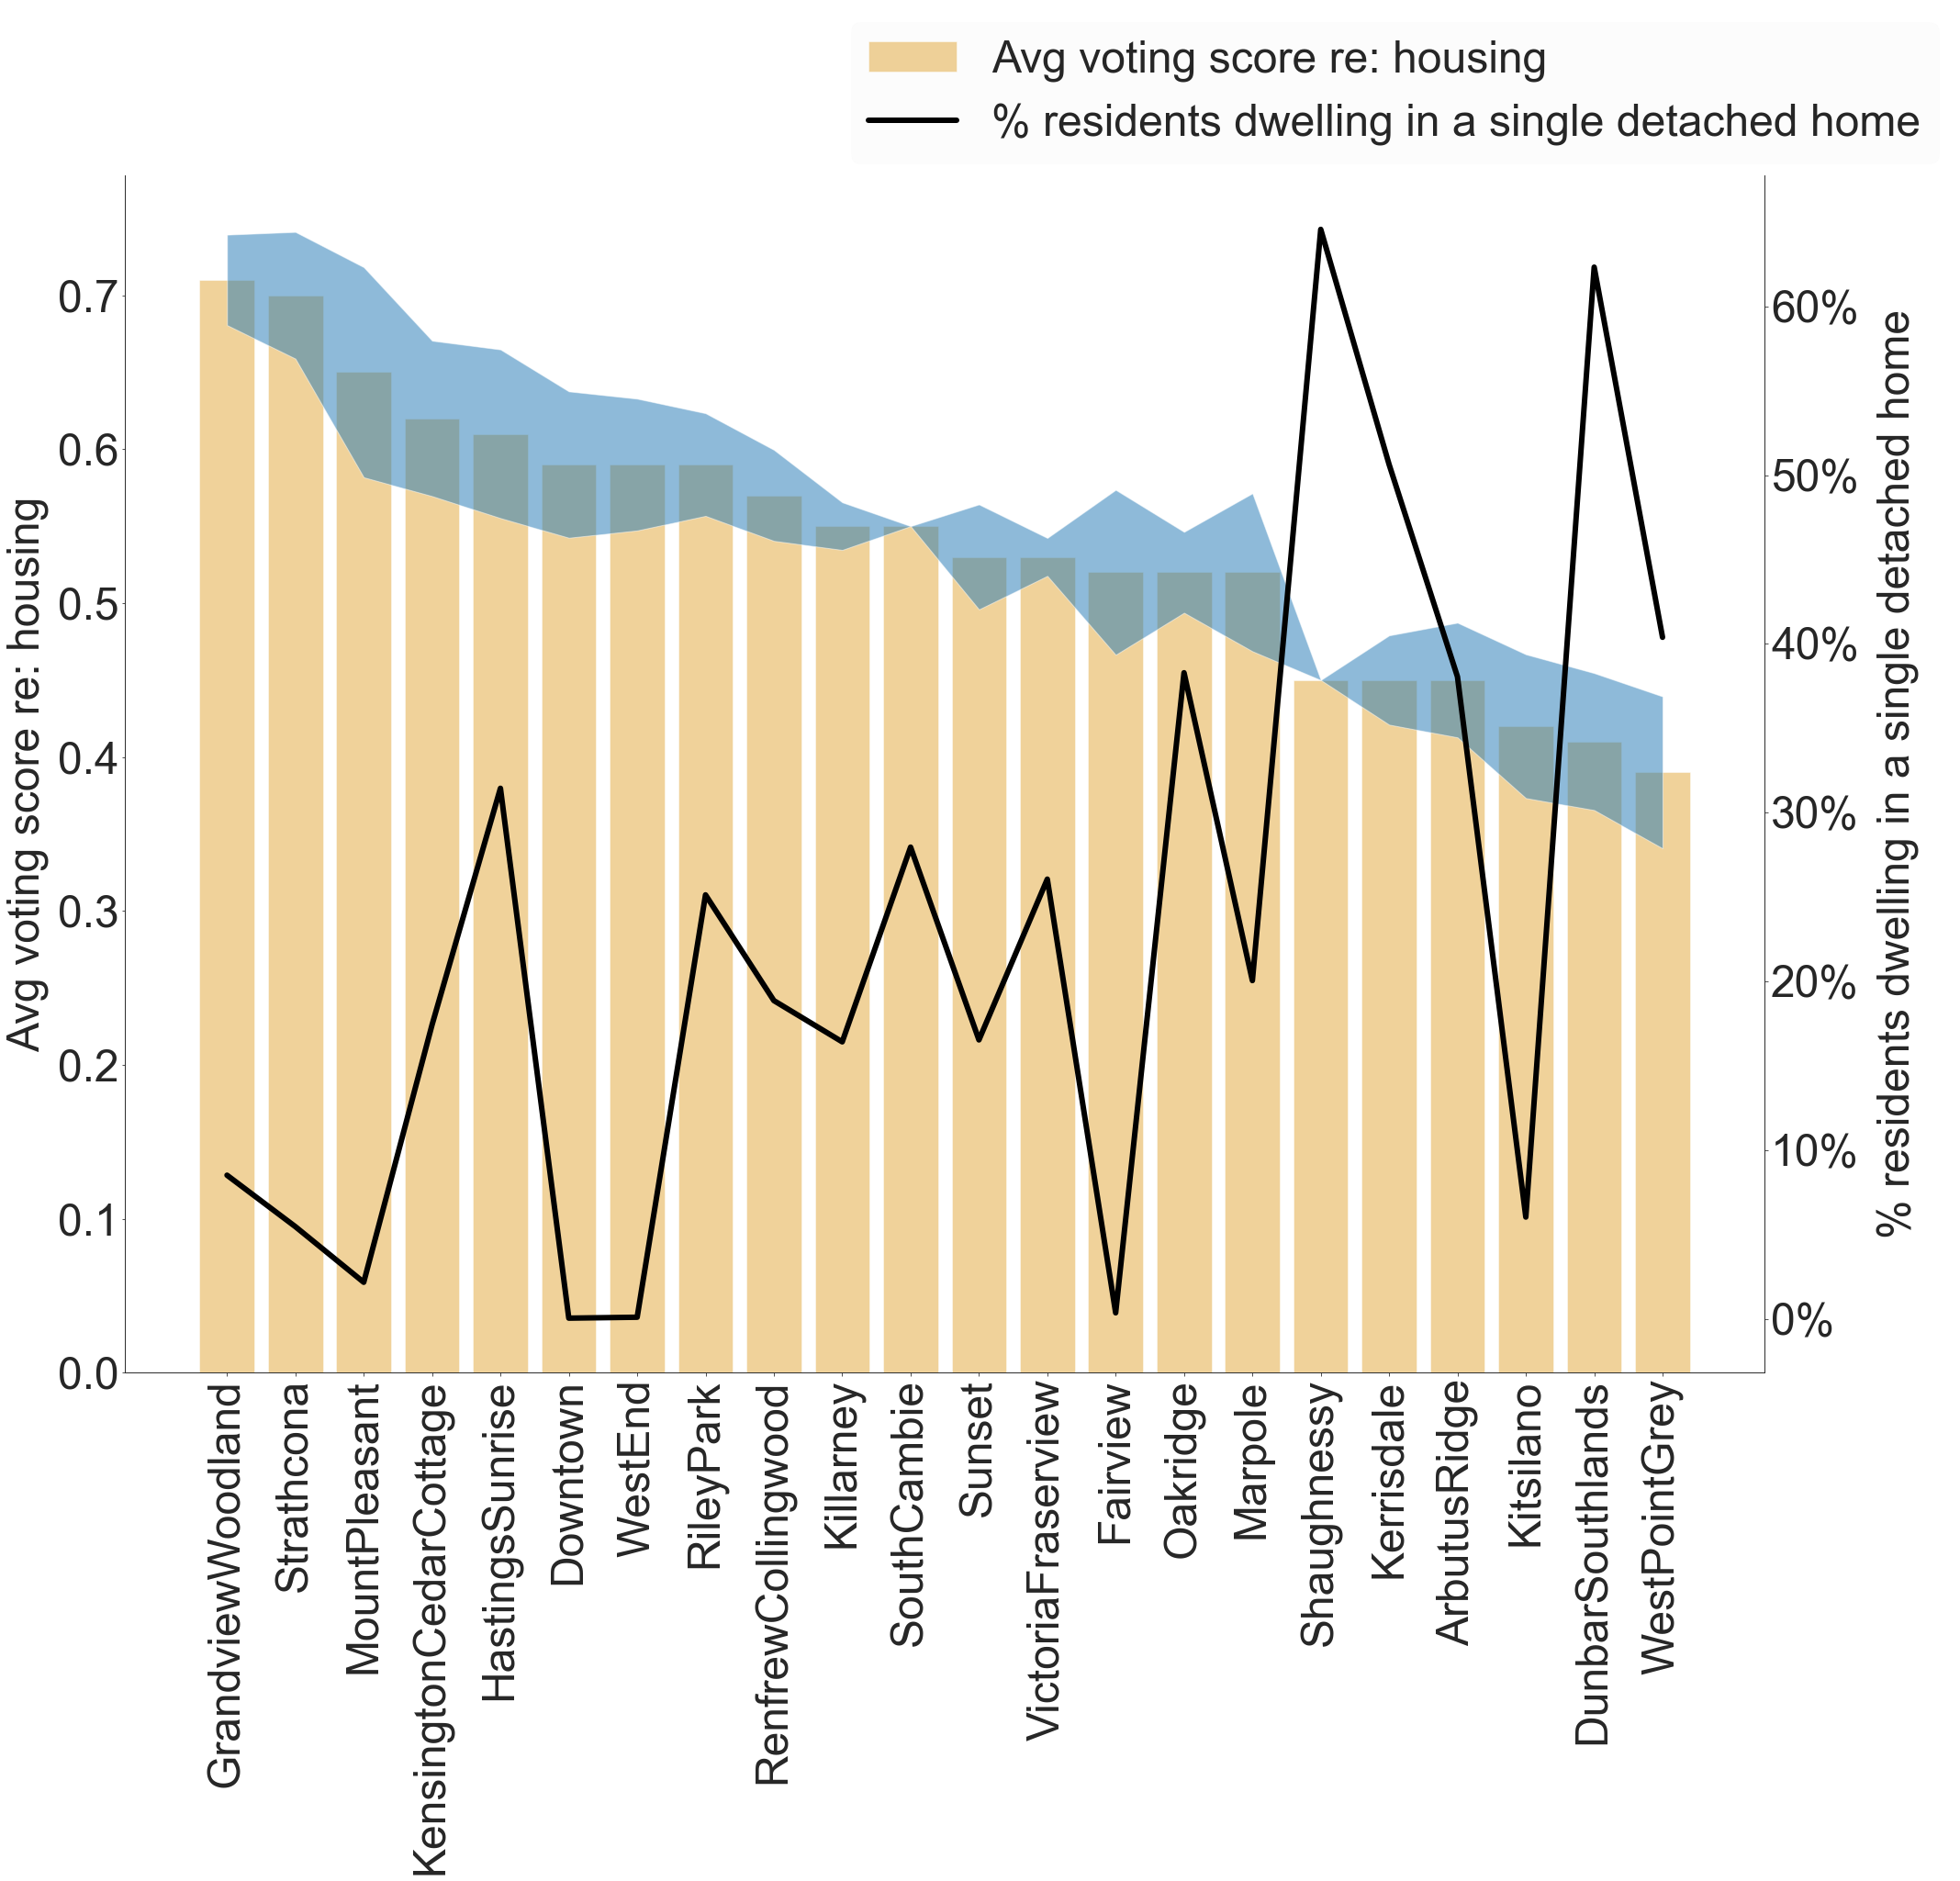

In [127]:
#----- Looking into election results per neighborhood along with the % of dwellings of multi type
df_2022_election_new = sqldf('select neighborhood, category, avg_score_neighborhood, stdev_neighborhood, percent_dwelling_single_detached from df_2022_election inner join percent_single_detached_nb on neighborhood = locale') 

voting_by_neighborhood = df_2022_election_new.drop_duplicates().sort_values(by=['avg_score_neighborhood'], 
                                                                            ascending=False).reset_index()

fig_5 = plt.figure()
ax6 = fig_5.add_subplot(111)
sns.barplot(data=voting_by_neighborhood, 
             x="neighborhood", y="avg_score_neighborhood", color = "orange", alpha = 0.45,
                   label = 'Avg voting score re: housing')

#----- Plotting the standard deviations in blue
ax6.fill_between(voting_by_neighborhood["neighborhood"], y1=voting_by_neighborhood["avg_score_neighborhood"] - 
                 voting_by_neighborhood["stdev_neighborhood"], 
                 y2=voting_by_neighborhood["avg_score_neighborhood"] + 
                 voting_by_neighborhood["stdev_neighborhood"], alpha=.5)

plt.xticks(rotation=90)
ax6.set_ylabel('Avg voting score re: housing', labelpad=10, fontsize = 48)
ax6.set_xlabel('')
ax6.tick_params(axis='both', which='major', labelsize=48)

ax7 = plt.twinx()
sns.lineplot(data=voting_by_neighborhood, 
             x="neighborhood", y="percent_dwelling_single_detached", color="black", ax=ax7, linewidth = 6,
                    label = '% residents dwelling in a single detached home', legend = False)
ax7.set_ylabel('% residents dwelling in a single detached home', labelpad = 20, fontsize = 48)
ax7.set_xlabel('')
ax7.tick_params(axis='both', which='major', labelsize=48)
ax7.yaxis.set_major_formatter(mtick.PercentFormatter())

fig_5.legend(loc="upper right", facecolor = 'black', framealpha = 0.01, fontsize = 48)

sns.despine(bottom = False, left = False, right = False)
plt.savefig('housing_voting_score_by_neighborhood.png', bbox_inches='tight')

#----- Running the Spearman Correlation calculation
correlation_voting, pvalue_voting = scp.spearmanr(voting_by_neighborhood[['avg_score_neighborhood']], 
                                                  voting_by_neighborhood[['percent_dwelling_single_detached']])
print(correlation_voting, pvalue_voting)

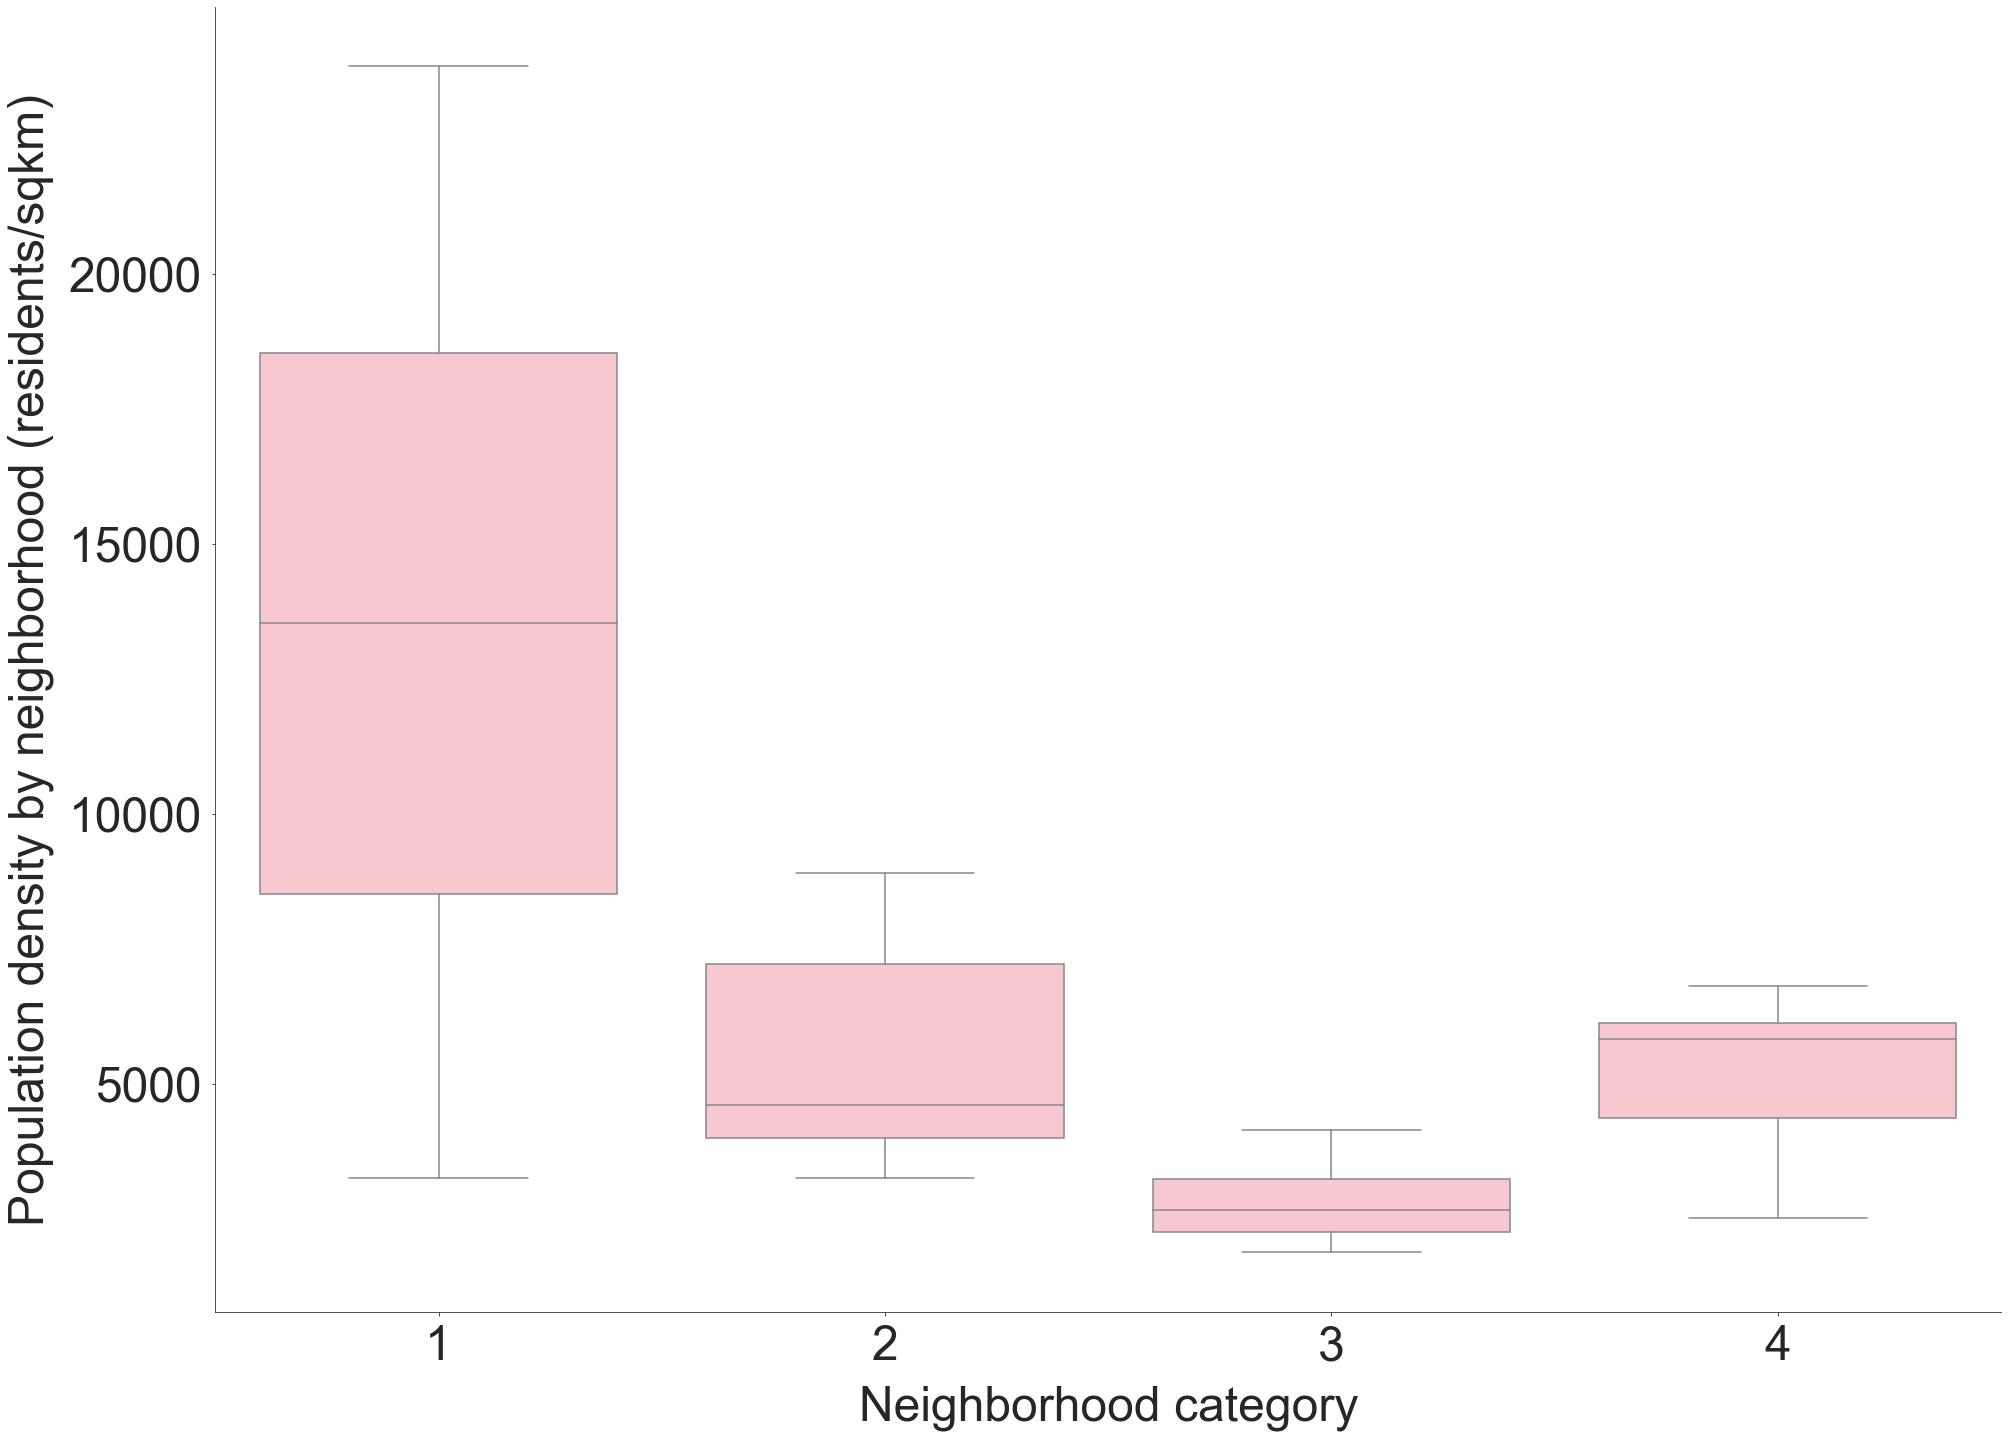

In [125]:
#----- Plotting population density by neighborhood, color coded to neighborhood category
pop_dens = df_population_density[['neighborhood', 'category', 
                                  'density_per_km2']].sort_values(by=['density_per_km2'], 
                                                                            ascending=False).reset_index()

fig_6 = plt.figure()
ax8 = fig_6.add_subplot(111)
sns.boxplot(data=pop_dens, 
             x="category", y="density_per_km2", color='pink')

ax8.set_ylabel('Population density by neighborhood (residents/sqkm)', labelpad=15, fontsize = 48)
ax8.set_xlabel('Neighborhood category', labelpad=15, fontsize = 48)
ax8.tick_params(axis='both', which='major', pad=10, labelsize=48)

sns.despine(bottom = False, left = False)
plt.savefig('population_density_by_neighborhood.png', bbox_inches='tight')